# Assignment — Cascades and influence maximization

In [ ]:
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
import networkx as nx
import matplotlib.pyplot as plt

###

This part of the assignment is devoted to models of influence propagation: the linear threshold model and independent cascade model. There are many applications of these types of models, for example:
* Rise of a political movement in an unstable society
* “Word-of-mouth” effects: when we have access to plentiful information, such as when we evaluate new technologies, risky financial assets, or job candidates, we often lack the ability to make sense of it; hence, we rely on the advice of trusted friends, colleagues, or advisors
* “Viral marketing” effects in the success of new products
* Adoption of medical and agricultural innovations
* Cascading failures in power systems
* Desicion making by majority voting

Let us consider these models on directed Erdos Renyi graph.

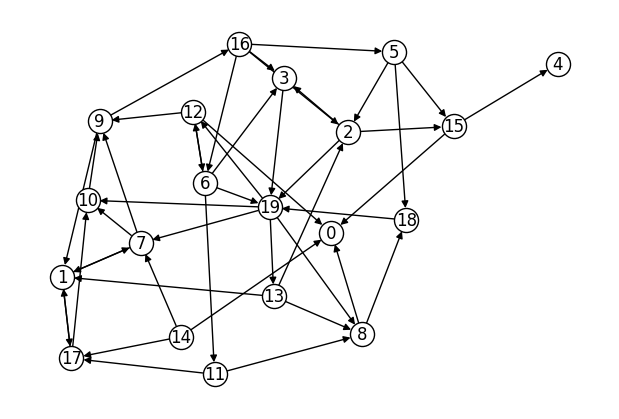

In [ ]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

### Task 1. Linear threshold model (0 points)

Linear threshold model is defined as follows. Given a choice of all nodes’ thresholds, and an initial set of active nodes, the diffusion process unfolds deterministically in discrete steps: in step $t$, all nodes that were
active in step $t-1$ remain active; furthermore, each currently inactive node becomes active if and only
if the total share of its active neighbors is at least node's threshold.

Write a function `linear_threshold` that takes a graph, np.array `active_nodes` with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active), np.array of `thresholds`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the propogation stops changing).

In [ ]:
def linear_threshold(G, active_nodes, thresholds):
    ### BEGIN SOLUTION
    simulation = [active_nodes]
    while True:
        new_active = active_nodes.copy()
        for node in np.argwhere(active_nodes == 0):
            node = node[0]
            predecessors = np.array([i for i in G.predecessors(node)])
            if not predecessors.shape[0]:
                continue
            if active_nodes[predecessors].sum() / predecessors.shape[0] >= thresholds[node]:
                new_active[node] = 1
        active_nodes = new_active.copy()
        simulation.append(active_nodes)
        if np.all(simulation[-1] == simulation[-2]):
            break
    return np.array(simulation)
    ### END SOLUTION

In [ ]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

In [ ]:
thresholds

array([0.57915493, 0.93996852, 0.63704323, 0.70711751, 0.64803997,
       0.81439395, 0.78991891, 0.7999646 , 0.63290956, 0.64234294,
       0.6267941 , 0.66378197, 0.57208215, 0.58280643, 0.98196526,
       0.98011336, 0.59420733, 0.51215328, 0.60227777, 0.84992181])

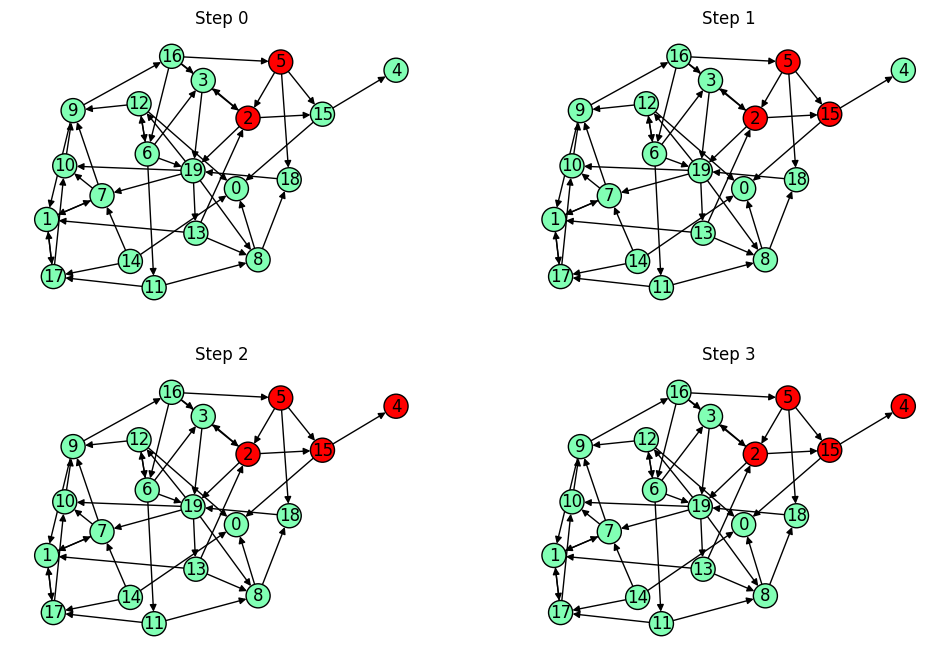

In [ ]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True,
            node_color=color+1,
            vmin=0, vmax=2,
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 2. Independent cascade model (7 points)

The next type is Independent cascade model. We again start with an initial set of active nodes, and the process unfolds in discrete steps according to the following randomized rule. When node $v$ first becomes active in step $t$, it is given a single chance to activate each currently inactive neighbor $w$; it succeeds with a probability $p_{v,w}$ — a parameter of the system — independently of the history thus far. (If $w$ has multiple newly activated neighbors, their attempts are sequenced in an arbitrary order.) If $v$ succeeds, then $w$ will become active in step $t+1$; but whether or not $v$ succeeds, it cannot make any further attempts to activate $w$ in subsequent steps.

Write a function `independent_cascade` that takes a graph, np.array active_nodes with zeros and ones (if active_nodes[i] is 1 then the i-th node is active), np.array with propagation probabilities `prop_proba` for edges ordered by `G.edges`. The function propagates influence and stops when the model stops changing. The function returns a np.array with active nodes in each step. The first step is initial activation, the last and the second to last steps are the same (we want to see that the model stops changing).

In [ ]:
def independent_cascade(G, active_nodes, prop_proba):
    ### BEGIN SOLUTION
    edges = list(G.edges)
    prop_proba = prop_proba.copy()
    active_nodes = active_nodes.copy()
    simulation = [active_nodes]

    t_act_nodes_id = np.argwhere(active_nodes == 1)

    while True:
        #print("START")
        new_active_nodes = simulation[-1].copy()
        #print(f't_act_nodes_id: {t_act_nodes_id}')
        for an in t_act_nodes_id:
          successors = list(G.successors(an[0]))
          #print(f'successors: {successors}')
          if len(successors) != 0:
            for n in successors:
              #print(prop_proba[edges.index((an, n))])
              if np.random.rand(1)[0] <= prop_proba[edges.index((an, n))]:
                new_active_nodes[n] = 1

        simulation.append(new_active_nodes)
        #print(simulation)

        if np.all(simulation[-1] == simulation[-2]):
            break

        t_act_nodes_id = np.argwhere(simulation[-1] - simulation[-2] == 1)
    return np.array(simulation)
    ### END SOLUTION

In [ ]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

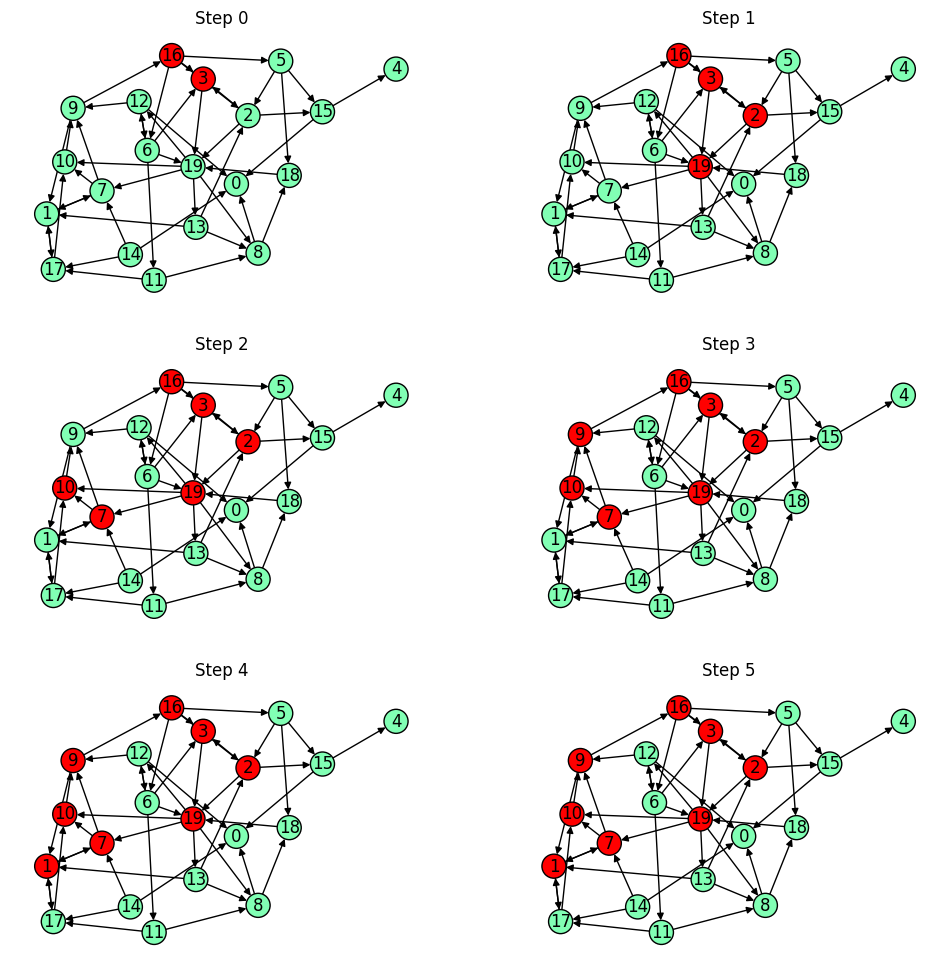

In [ ]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True,
            node_color=color+1,
            vmin=0, vmax=2,
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

### Task 3. Influence maximization problem (3 points)

The influence is the expected number of active nodes at the end of the process

$$\sigma(A_0) = \mathbb E[|A_t|]$$

where $A_0$ is an initial active nodes and $A_t$ is an active nodes at the end. Linear threshold model is deterministic and then $E[|A_t|] = |A_t|$.

The influence maximization problem asks, for a given number of initial active nodes $k$, to find a set of nodes that gives maximum influence. It is NP-hard problem, but a useful property is that it can be solved in polynomial time by greedy optimization with guaranteed performance slightly better than 63%. Proofs are [here](https://theoryofcomputing.org/articles/v011a004/v011a004.pdf). The algorithm is:

1. Let $A_0 = \emptyset$
2. For every node $i$, calculate the influence $\sigma(A_0 \cup \{i\})$
3. Put the node with the largest influence into the initial active set $A_0 = A_0 \cup \{i\}$
4. Repeat 2-3 until $|A_0| = k$

Write a function `greedy_influence_max` that takes a graph, `thresholds` of linear threshold model, number of active nodes `k` and calculates initial active nodes by greedy algorithm. The function returns a np.array with zeros and ones (if `active_nodes[i]` is 1 then the i-th node is active).

In [ ]:
def greedy_influence_max(G, thresholds, k):
    ### BEGIN SOLUTION
    best_active = np.zeros(len(G))
    max_influence = k
    for i in range(k):
        active = best_active.copy()
        for node in np.argwhere(active == 0):
            new_active = active.copy()
            new_active[node[0]] = 1
            sim = linear_threshold(G, new_active, thresholds)
            if sim[-1].sum() > max_influence:
                best_active = new_active.copy()
                max_influence = sim[-1].sum()
    return best_active
    ### END SOLUTION

In [ ]:
n = 100
G = nx.erdos_renyi_graph(n, 0.07, 0, True)

np.random.seed(0)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.1, 0.8, n)

best_active = greedy_influence_max(G, thresholds, 2)
assert best_active.shape == (100,)
assert best_active.sum() == 2
sim = linear_threshold(G, best_active, thresholds)
assert sim[-1].sum() > 21 * 0.63

Here is the same model as in the linear threshold task, but with a better initial active set.

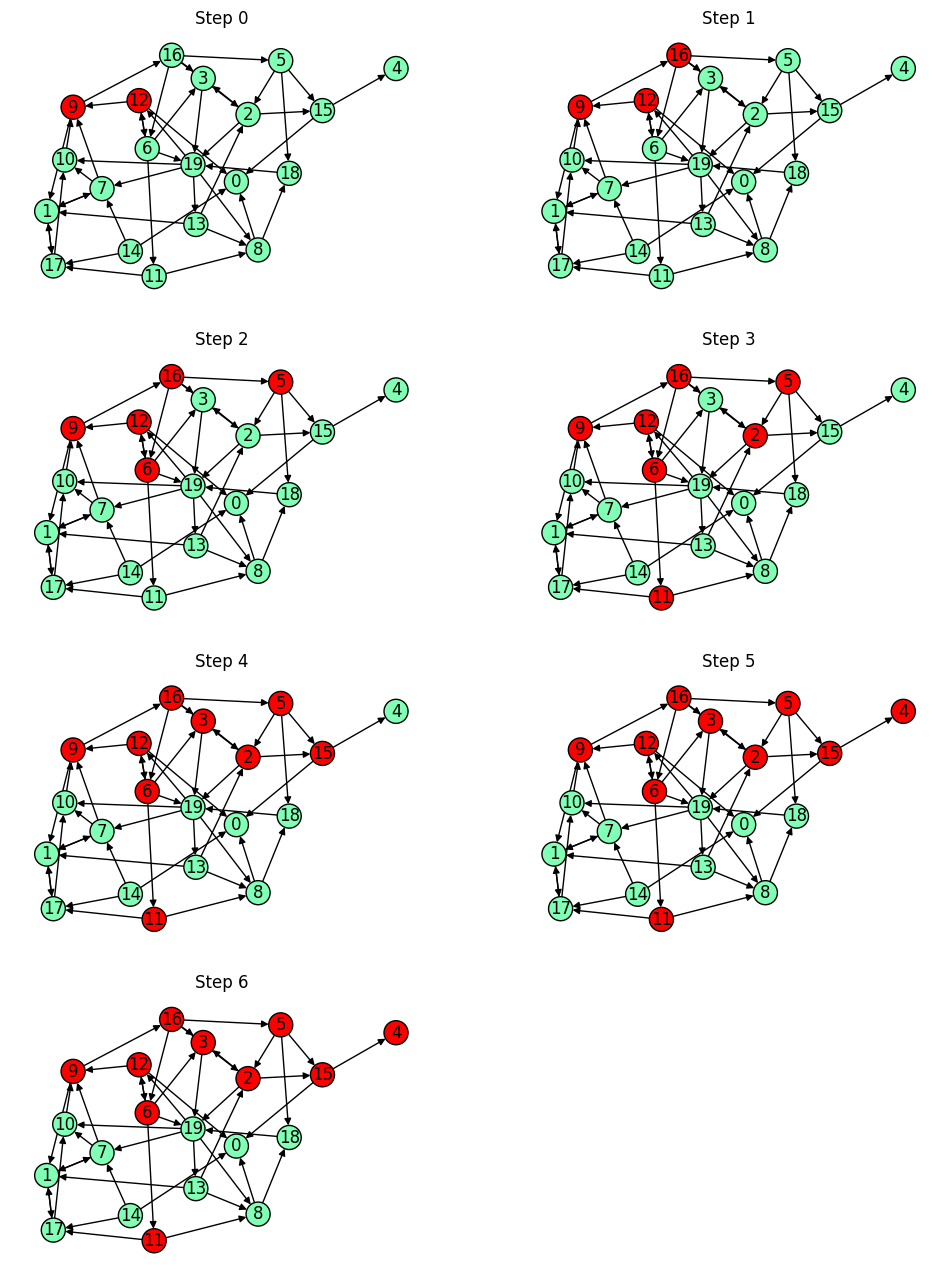

In [ ]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

best_active = greedy_influence_max(G, thresholds, 2)
sim = linear_threshold(G, best_active, thresholds)

plt.figure(figsize=(6*2, 4*4))

for i, color in enumerate(sim):
    plt.subplot(4, 2, i+1)
    nx.draw(G, pos, with_labels=True,
            node_color=color+1,
            vmin=0, vmax=2,
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()